## 3) Build an Interest Rate ESG
Our objective is to first build a model fit to historical treasury yields, then use it to simulate future yeilds by adding random noise. To acheive this, we will be using a very comprehensive statistical package for python, 'statsmodels'.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Load Historical Treasury Rates
Recall the historical treasury rate dataset we cleaned before.

In [2]:
###Load cleaned dataset from local directory
treasury_frame = pd.read_csv('C:/Box/rlee/Workspace/Python Workshops/FRB_H15_clean.csv', index_col = 'Date')
treasury_frame.head()

,yield_1mo,yield_3mo,yield_6mo,yield_1yr,yield_2yr,yield_3yr,yield_5yr,yield_7yr,yield_10yr,yeild_20yr,yield_30yr
Date,,,,,,,,,,,
2001-07-31,3.67,3.54,3.47,3.53,3.79,4.06,4.57,4.86,5.07,5.61,5.51
2001-08-01,3.65,3.53,3.47,3.56,3.83,4.09,4.62,4.90,5.11,5.63,5.53
2001-08-02,3.65,3.53,3.46,3.57,3.89,4.17,4.69,4.97,5.17,5.68,5.57
2001-08-03,3.63,3.52,3.47,3.57,3.91,4.22,4.72,4.99,5.20,5.70,5.59
2001-08-06,3.62,3.52,3.47,3.56,3.88,4.17,4.71,4.99,5.19,5.70,5.59


In [3]:
###What is the shape of this dataset, and how to interpret?
treasury_frame.shape

(3595, 11)

#### Yield Curve Fitting
We will use Nelson-Siegal model to estimate the yield curve, then simulate the beta coefficients. 

The below equation gives the yield _y_ for a Treasury maturing at time _t_. _y(t)_ for _t_ ranging from 3-months to 30-years makes up one yield curve. Yield curves will vary from day-to-day as market prices of treasury bonds change.

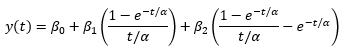

To make things easier, we will fix the parameter alpha = 1.4, which will turn the NS factors into constants for each tenor.

#### TASK 1

If lambda is fixed, then the expressions multiplying with the beta coefficients only vary by t. Let's call them the NS factors. Write a function that returns the NS factors to our Nelson-Siegal model for a given list of tenors.

In [4]:
tenors = np.array([1. / 12., 3. / 12, 6. / 12, 1., 2., 3., 5., 7., 10., 20., 30.])

def NS_factors_function(tenors, alpha = 1.4):
    tau = tenors / alpha
    NS_factors = np.ones((len(tenors), 3))
    
    NS_factors[:, 1] = (1. - np.exp(-tau)) / tau
    NS_factors[:, 2] = NS_factors[:, 1] - np.exp(-tau)
    return NS_factors

NS_factors_function(tenors)

array([[1.        , 0.97081993, 0.02860683],
       [1.        , 0.91579988, 0.07933557],
       [1.        , 0.8409169 , 0.14124436],
       [1.        , 0.71464168, 0.22510002],
       [1.        , 0.53224427, 0.29259324],
       [1.        , 0.41191772, 0.29459856],
       [1.        , 0.27212762, 0.24401196],
       [1.        , 0.19865241, 0.19191446],
       [1.        , 0.13988933, 0.13909884],
       [1.        , 0.06999996, 0.06999933],
       [1.        , 0.04666667, 0.04666667]])

In [5]:
###Save these factors for use later by storing in a dataframe
NS_factors = NS_factors_function(tenors)
pd.DataFrame(NS_factors, columns = ['X0', 'X1', 'X2'])

,X0,X1,X2
0,1.0,0.970820,0.028607
1,1.0,0.915800,0.079336
2,1.0,0.840917,0.141244
3,1.0,0.714642,0.225100
4,1.0,0.532244,0.292593
5,1.0,0.411918,0.294599
6,1.0,0.272128,0.244012
7,1.0,0.198652,0.191914
8,1.0,0.139889,0.139099
9,1.0,0.070000,0.069999


Our Nelson-Siegal model now looks something like this (look familiar?):
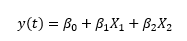

#### Linear Regression
We will use a OLS regression to estimate the beta coefficients of our Nelson-Siegal model, fitting to history.

#### TASK 2

Fit a linear regression to a single historical yeild curve.

In [6]:
treasury_frame.values[0, :]

array([3.67, 3.54, 3.47, 3.53, 3.79, 4.06, 4.57, 4.86, 5.07, 5.61, 5.51])

In [7]:
from statsmodels.api import OLS

model = OLS(treasury_frame.values[0, :], NS_factors).fit()
model.params

array([ 5.8634166 , -2.25762727, -3.0075851 ])

In [8]:
betas = model.params
model_curve = np.sum(NS_factors * betas, axis = 1)
model_curve

array([3.5856296 , 3.55727334, 3.54013526, 3.57301461, 3.78180835,
       4.04742969, 4.51516716, 4.83773442, 5.12924703, 5.49485384,
       5.61770669])

Lets visually examine the regression to see how well it fit to the historical yeild curve.

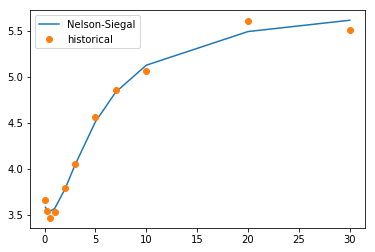

In [9]:
plt.plot(tenors, model_curve)
plt.plot(tenors, treasury_frame.values[0, :], 'o')
plt.legend(['Nelson-Siegal', 'historical'])
plt.show()

#### TASK 3
Wrap what we just did in task 2 into functions, so that it can be easily applied to our entire dataset.

In [10]:
def NS_model_fit(historical_yields, NS_factors):
    model = OLS(historical_yields, NS_factors).fit()
    betas = model.params
    return betas


def NS_model_curve(betas, NS_factors):    
    model_curve = np.sum(NS_factors * betas, axis = 1)
    return model_curve

    
def plot_NS_yield_curve(NS_curve, historical_curve = None, tenors = tenors):
    plt.plot(tenors, NS_curve)
    if historical_curve is not None:
        plt.plot(tenors, historical_curve, 'o')
        plt.legend(['Nelson-Siegal', 'historical'])
    plt.show()

[ 5.8634166  -2.25762727 -3.0075851 ]
[3.5856296  3.55727334 3.54013526 3.57301461 3.78180835 4.04742969
 4.51516716 4.83773442 5.12924703 5.49485384 5.61770669]


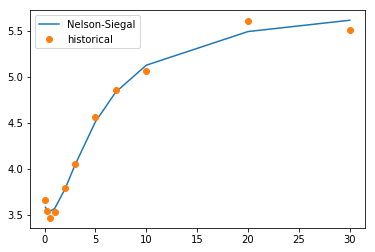

In [11]:
betas = NS_model_fit(treasury_frame.values[0, :], NS_factors)
print(betas)

model_curve = NS_model_curve(betas, NS_factors)
print(model_curve)

plot_NS_yield_curve(model_curve, treasury_frame.values[0, :])

#### TASK 4
Loop through all historical yield curves to estimate a set of betas for each historical yield curve using the functions we created in task 3.

In [12]:
historical_NS_betas = [NS_model_fit(treasury_frame.values[i, :], NS_factors) for i in range(treasury_frame.shape[0])]
historical_NS_betas = pd.DataFrame(historical_NS_betas, columns = ('beta0', 'beta1', 'beta2'))
historical_NS_betas.head(10)

,beta0,beta1,beta2
0,5.863417,-2.257627,-3.007585
1,5.880529,-2.299996,-2.854480
2,5.925263,-2.369989,-2.685726
3,5.941117,-2.408157,-2.576902
4,5.950574,-2.412161,-2.693013
5,5.958665,-2.420246,-2.663153
6,5.856304,-2.323793,-2.935377
7,5.894350,-2.388192,-2.872176
8,5.864144,-2.376607,-2.938896
9,5.862920,-2.361314,-3.067086


Lets spot check a few curves. Do they look good?

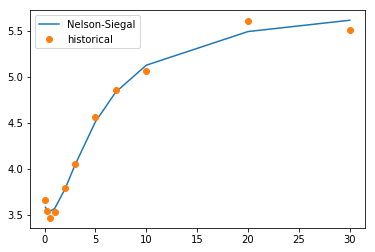

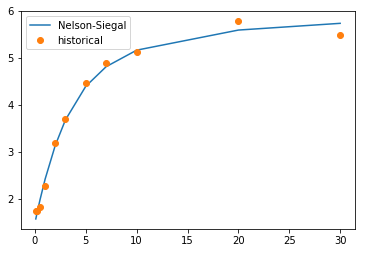

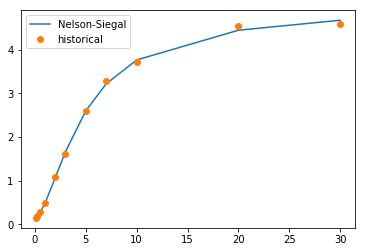

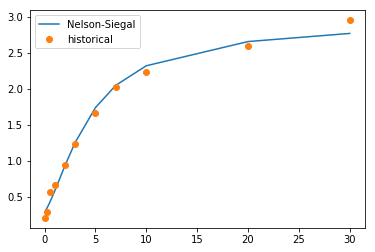

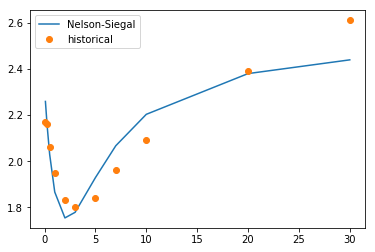

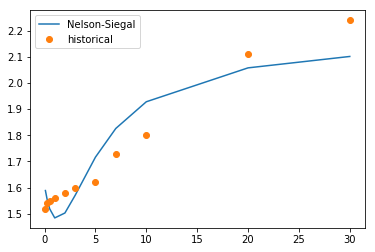

In [13]:
for i in [0, 100, 1000, -1000, -100, -1]:
    plot_NS_yield_curve(
        NS_model_curve(historical_NS_betas.iloc[i, :].values, NS_factors), 
        treasury_frame.values[i, :])

#### Forecasting Beta Coefficients
We now obtained historical time series of each beta coefficient for the NS-model. Now we will build a model that can forecast future betas. To do this, we will use a Vector Auto-Regressive (VAR) Model. 

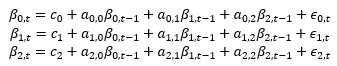

#### TASK 5
Fit a VAR model to our historical beta coefficients obtained from Task 4. Then forecast betas for the next year (250 trading days) in the future.

In [14]:
from statsmodels.tsa.api import VAR

VAR_model = VAR(historical_NS_betas).fit()
print(f'VAR Lag Order: {VAR_model.k_ar}')
VAR_model.summary()

VAR Lag Order: 1


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 28, Mar, 2020
Time:                     21:33:16
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -14.3973
Nobs:                     3594.00    HQIC:                  -14.4106
Log likelihood:           10622.0    FPE:                5.47493e-07
AIC:                     -14.4179    Det(Omega_mle):     5.45669e-07
--------------------------------------------------------------------
Results for equation beta0
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.007842         0.004327            1.812           0.070
L1.beta0         0.998015         0.001116          894.354           0.000
L1.beta1         0.001161         0.001095            1.059           0.289
L1.b

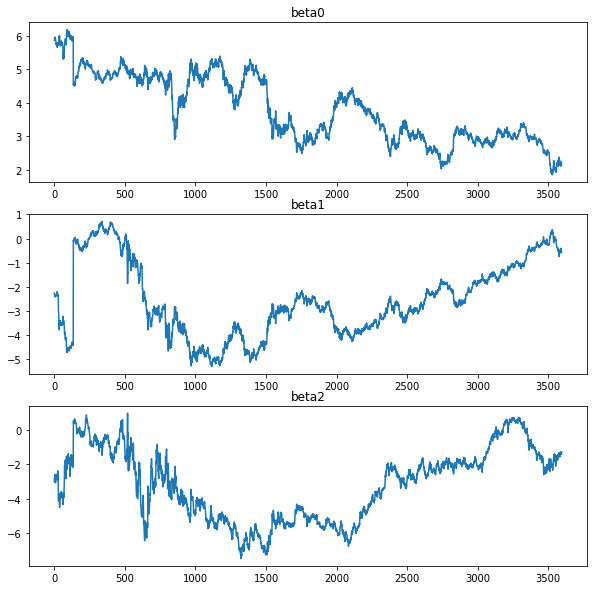

In [15]:
VAR_model.plot()
plt.show()

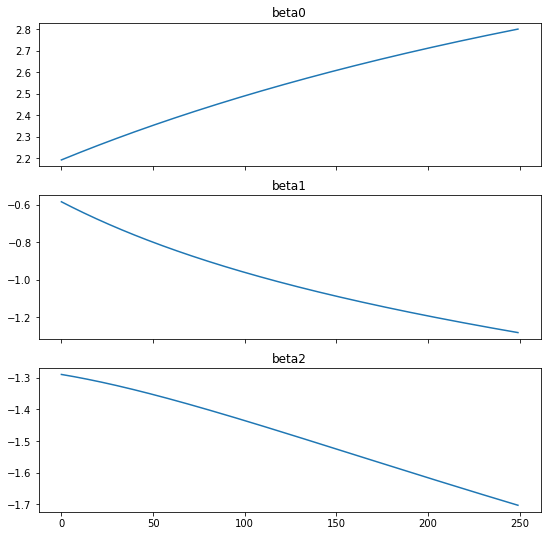

In [16]:
###Forecast future beta values for next year
forecasted_NS_betas = VAR_model.forecast(historical_NS_betas.iloc[-VAR_model.k_ar:, :].values, 250)

fig, ax = plt.subplots(3, 1, figsize = (9, 9), sharex = True)
ax = ax.flatten()
for i in range(3):
    ax[i].plot(forecasted_NS_betas[:, i])
    ax[i].set_title(f'beta{i}')
plt.show()

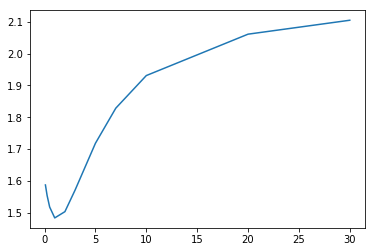

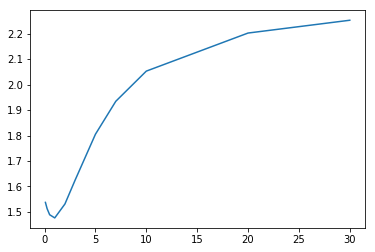

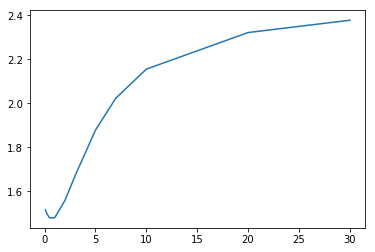

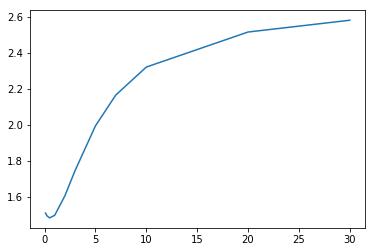

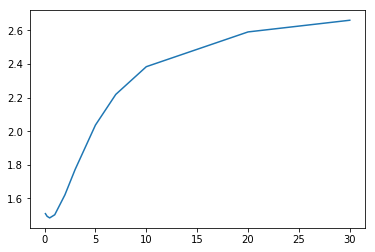

In [17]:
###Splot check a few forecasted yield curves using the forecasted betas
for i in [0, 50, 100, 200, -1]:
    plot_NS_yield_curve(NS_curve = NS_model_curve(forecasted_NS_betas[i], NS_factors = NS_factors))

#### Simulation
Our VAR model can now produce forecasts of the __expected path__ for each beta coefficient in the NS-model. To turn these forecasts into simulations, we need to add randomness to the VAR predictions. This will give us a __distribution__ of future paths, _aka_ stochastic simulation.

#### TASK 6

Simulate __10000 trials__ of yield curves for __250 days__, with each yield curve described by __3 beta coefficients__ of a NS-model. Plot the generated time series of betas and visually inspect results for reasonableness.

(10000, 250, 3)


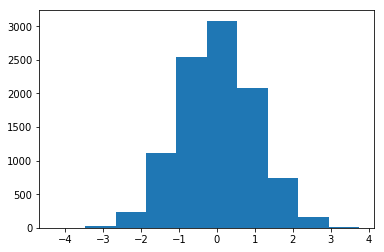

In [18]:
###To do simulation, we need to generate some random draws from a multivariate normal distribution
random_noise = np.random.multivariate_normal(mean = np.zeros(3), cov = VAR_model.resid_corr, size = (10000, 250))
print(random_noise.shape)

plt.hist(random_noise[:, 0, 0])
plt.show()

In [19]:
simulated_NS_betas = forecasted_NS_betas + random_noise
simulated_NS_betas.shape

(10000, 250, 3)

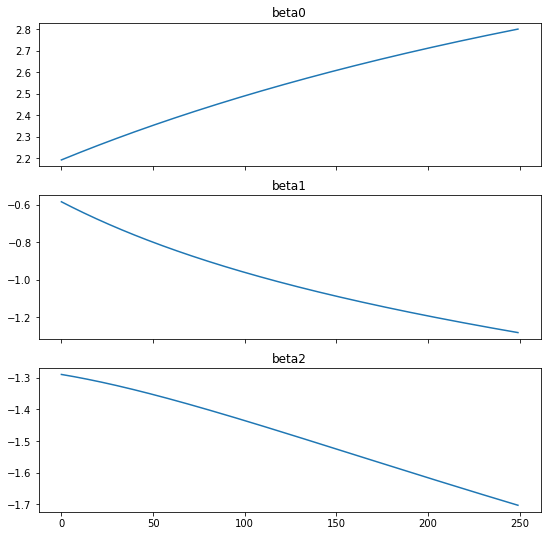

In [20]:
def plot_beta_time_series(beta_series):
    fig, ax = plt.subplots(3, 1, figsize = (9, 9), sharex = True)
    ax = ax.flatten()
    for i in range(3):
        ax[i].plot(beta_series[:, i])
        ax[i].set_title(f'beta{i}')
    plt.show()
plot_beta_time_series(forecasted_NS_betas)

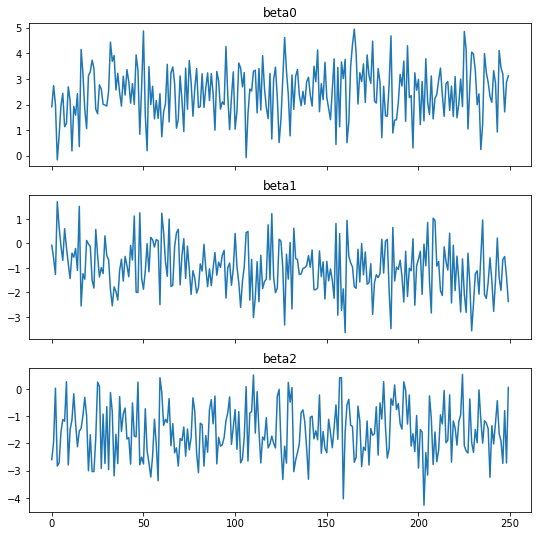

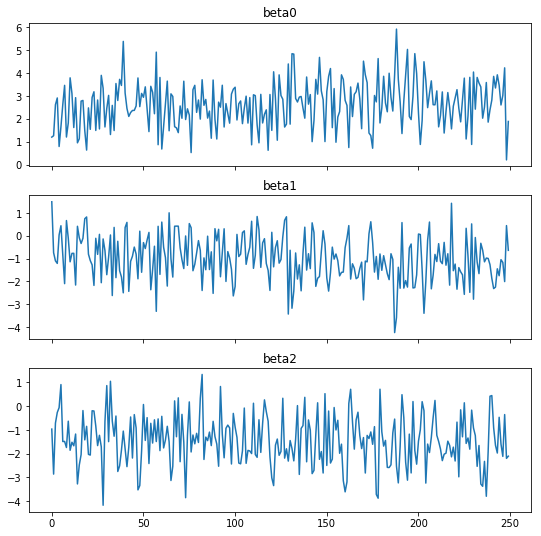

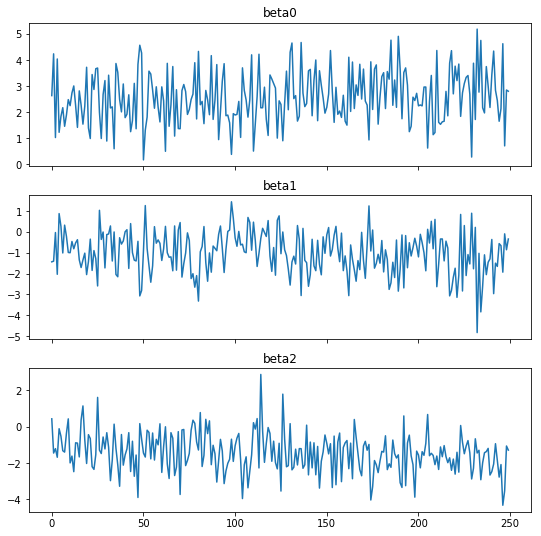

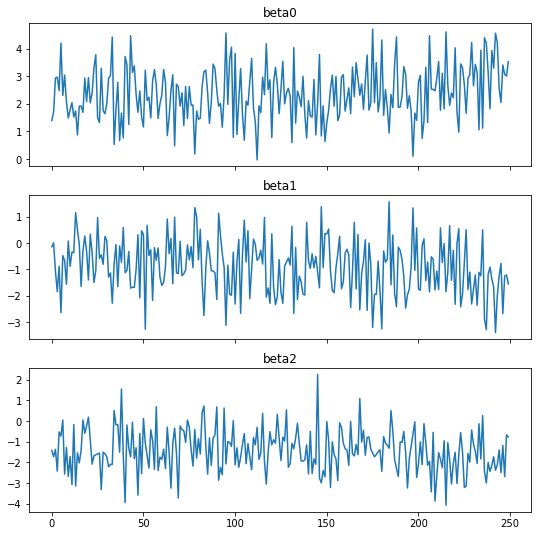

In [21]:
###Lets spot check a few scenarios
plot_beta_time_series(simulated_NS_betas[1, :, :])
plot_beta_time_series(simulated_NS_betas[10, :, :])
plot_beta_time_series(simulated_NS_betas[100, :, :])
plot_beta_time_series(simulated_NS_betas[-11, :, :])

#### TASK 7
Turn the simulation of betas from Task 6 into simulations of yield curves.

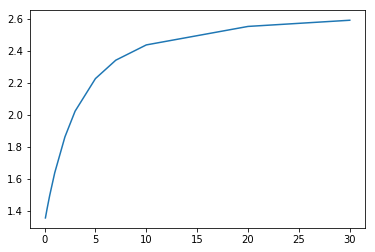

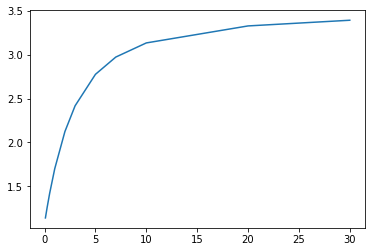

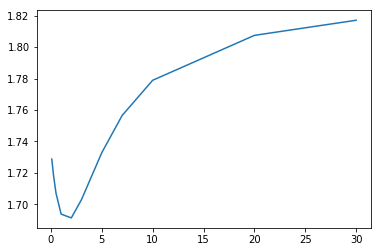

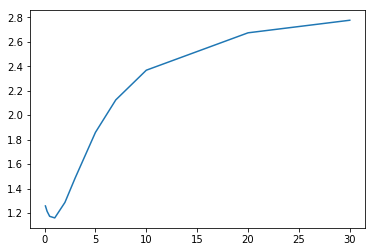

In [22]:
###Lets spot check a few yield curves
plot_NS_yield_curve(NS_curve = NS_model_curve(simulated_NS_betas[0, 30, :], NS_factors))
plot_NS_yield_curve(NS_curve = NS_model_curve(simulated_NS_betas[0, 120, :], NS_factors))
plot_NS_yield_curve(NS_curve = NS_model_curve(simulated_NS_betas[1000, 30, :], NS_factors))
plot_NS_yield_curve(NS_curve = NS_model_curve(simulated_NS_betas[1000, 200, :], NS_factors))

In [23]:
simulated_yield_curves = np.empty((500, 250, 11)) #cutting down on the sample to run faster
simulated_yield_curves[:] = np.nan
for i in range(500):
    for j in range(250):
        simulated_yield_curves[i, j, :] = NS_model_curve(simulated_NS_betas[i, j, :], NS_factors = NS_factors)
simulated_yield_curves.shape

(500, 250, 11)

In [24]:
simulated_yield_curves

array([[[ 1.38926991,  1.36232869,  1.33375826, ...,  1.72655218,
          1.843899  ,  1.88337505],
        [ 1.68216087,  1.5786732 ,  1.45977933, ...,  2.13698046,
          2.41649229,  2.51061984],
        [ 1.53258292,  1.49121388,  1.45039936, ...,  2.33137409,
          2.56877373,  2.64860327],
        ...,
        [ 2.05468571,  1.99962706,  1.93674735, ...,  2.33117633,
          2.48691476,  2.53935424],
        [ 2.51956286,  2.38288881,  2.21913712, ...,  2.50161714,
          2.7447637 ,  2.82676174],
        [-0.49304493, -0.34642641, -0.14552651, ...,  1.84532893,
          2.05684671,  2.1275139 ]],

       [[ 1.7650926 ,  1.63757636,  1.48252431, ...,  1.53949079,
          1.72380534,  1.78602288],
        [ 2.0948753 ,  2.02969306,  1.95480407, ...,  2.38106244,
          2.55705669,  2.61632403],
        [ 0.76966958,  0.84082853,  0.93746529, ...,  1.82489878,
          1.91132986,  1.94017797],
        ...,
        [ 1.17114197,  1.16012853,  1.15081089, ...,  

#### TASK 8
Plot the distribution of simulated 10 year treasury yields. How does it compare to the historical distribution?

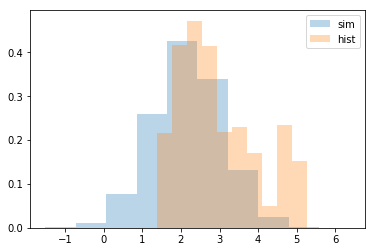

In [25]:
plt.hist(simulated_yield_curves[:, :, 8].flatten(), density = True, alpha = 0.3)
plt.hist(treasury_frame.values[:, 8], density = True, alpha = 0.3)
plt.legend(['sim', 'hist'])
plt.show()

#### TASK 9
What is the average correlation between 1-month treasury and 30-year treasury yields according to our simulation? How does this value compare to history? What is its distribution?

In [26]:
corr = np.array([np.corrcoef(simulated_yield_curves[i, :, 0], simulated_yield_curves[i, :, -1])[0, 1] for i in range(500)])
corr.mean()

0.41154717437655336

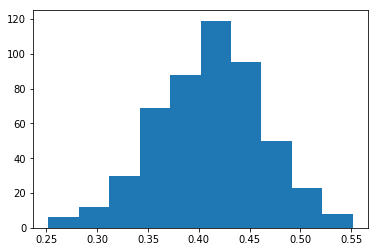

In [27]:
plt.hist(corr)
plt.show()

In [28]:
treasury_frame.corr()

,yield_1mo,yield_3mo,yield_6mo,yield_1yr,yield_2yr,yield_3yr,yield_5yr,yield_7yr,yield_10yr,yeild_20yr,yield_30yr
yield_1mo,1.000000,0.997823,0.993547,0.987984,0.970255,0.945656,0.877587,0.802045,0.716841,0.561455,0.511664
yield_3mo,0.997823,1.000000,0.997968,0.993647,0.977010,0.952569,0.884083,0.807683,0.721578,0.563727,0.512390
yield_6mo,0.993547,0.997968,1.000000,0.997929,0.983187,0.959674,0.892042,0.815366,0.729308,0.570057,0.515769
yield_1yr,0.987984,0.993647,0.997929,1.000000,0.991520,0.971847,0.908340,0.833291,0.746192,0.585847,0.528796
yield_2yr,0.970255,0.977010,0.983187,0.991520,1.000000,0.993284,0.948010,0.883673,0.799208,0.643018,0.584607
yield_3yr,0.945656,0.952569,0.959674,0.971847,0.993284,1.000000,0.976511,0.926566,0.849904,0.703420,0.645996
yield_5yr,0.877587,0.884083,0.892042,0.908340,0.948010,0.976511,1.000000,0.984832,0.937006,0.824296,0.776086
yield_7yr,0.802045,0.807683,0.815366,0.833291,0.883673,0.926566,0.984832,1.000000,0.980861,0.903648,0.866409
yield_10yr,0.716841,0.721578,0.729308,0.746192,0.799208,0.849904,0.937006,0.980861,1.000000,0.967647,0.943025
yeild_20yr,0.561455,0.563727,0.570057,0.585847,0.643018,0.703420,0.824296,0.903648,0.967647,1.000000,0.990452
